In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import os
from datetime import datetime

In [4]:
script_dir = os.path.abspath('')

In [5]:
def plot_fund_flow_line(plt, ticker):
    fund_flow_df = pd.read_excel(os.path.join(script_dir, f"data\{ticker}_fund_flow_data.xlsx"))
    fund_flow_df["asOf"] = pd.to_datetime(fund_flow_df["asOf"])

    plt.figure(figsize=(10, 6))
    plt.plot(
        fund_flow_df["asOf"],
        fund_flow_df["value"],
        marker="o",
        color="b",
        label="Fund Movement",
    )
    plt.axhline(0, color="gray", linewidth=0.5)
    plt.title("Daily Fund Inflow and Outflow for VCLT")
    plt.xlabel("Date")
    plt.ylabel("Fund Movement ($)")
    plt.xticks(rotation=45)
    plt.grid(visible=True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def plot_fund_flow_ticks(ticker, tick_freq):
    fund_flow_df = pd.read_excel(os.path.join(script_dir, f"data/flow/{ticker}_fund_flow_data.xlsx"))
    fund_flow_df["asOf"] = pd.to_datetime(fund_flow_df["asOf"])

    dates = fund_flow_df['asOf']
    mask = dates.index % tick_freq == 0  
    selected_dates = dates[mask]

    fig, ax = plt.subplots(figsize=(17, 8))

    for index, row in fund_flow_df.iterrows():
        if row["value"] > 0:
            color = "green"
            dx = 0
            dy = row["value"]
            y = 0  
        else:
            color = "red"
            dx = 0
            dy = -row["value"]
            y = row["value"]  

        # Adding an arrow to the plot
        ax.arrow(
            row["asOf"],  
            y,
            dx,
            dy,
            head_width=0.15,  
            head_length=abs(dy) * 0.3,  
            fc=color,  
            ec=color,
        ) 
        
    ax.set_title(f"Daily Fund Inflow and Outflow for {ticker} with Directional Indicators")
    ax.set_xlabel("Date")
    ax.set_ylabel("Fund Movement ($1e6)")

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    # ax.set_xticks(fund_flow_df["asOf"])
    ax.set_xticks(selected_dates)

    plt.xticks(rotation=45)
    plt.grid(visible=True, linestyle="--", linewidth=0.5)

    ax.axhline(0, color="black", linewidth=0.6)

    # Adjusting the layout and showing the plot
    plt.tight_layout()
    plt.show()

### Long Duration Treasuries Fund Watch

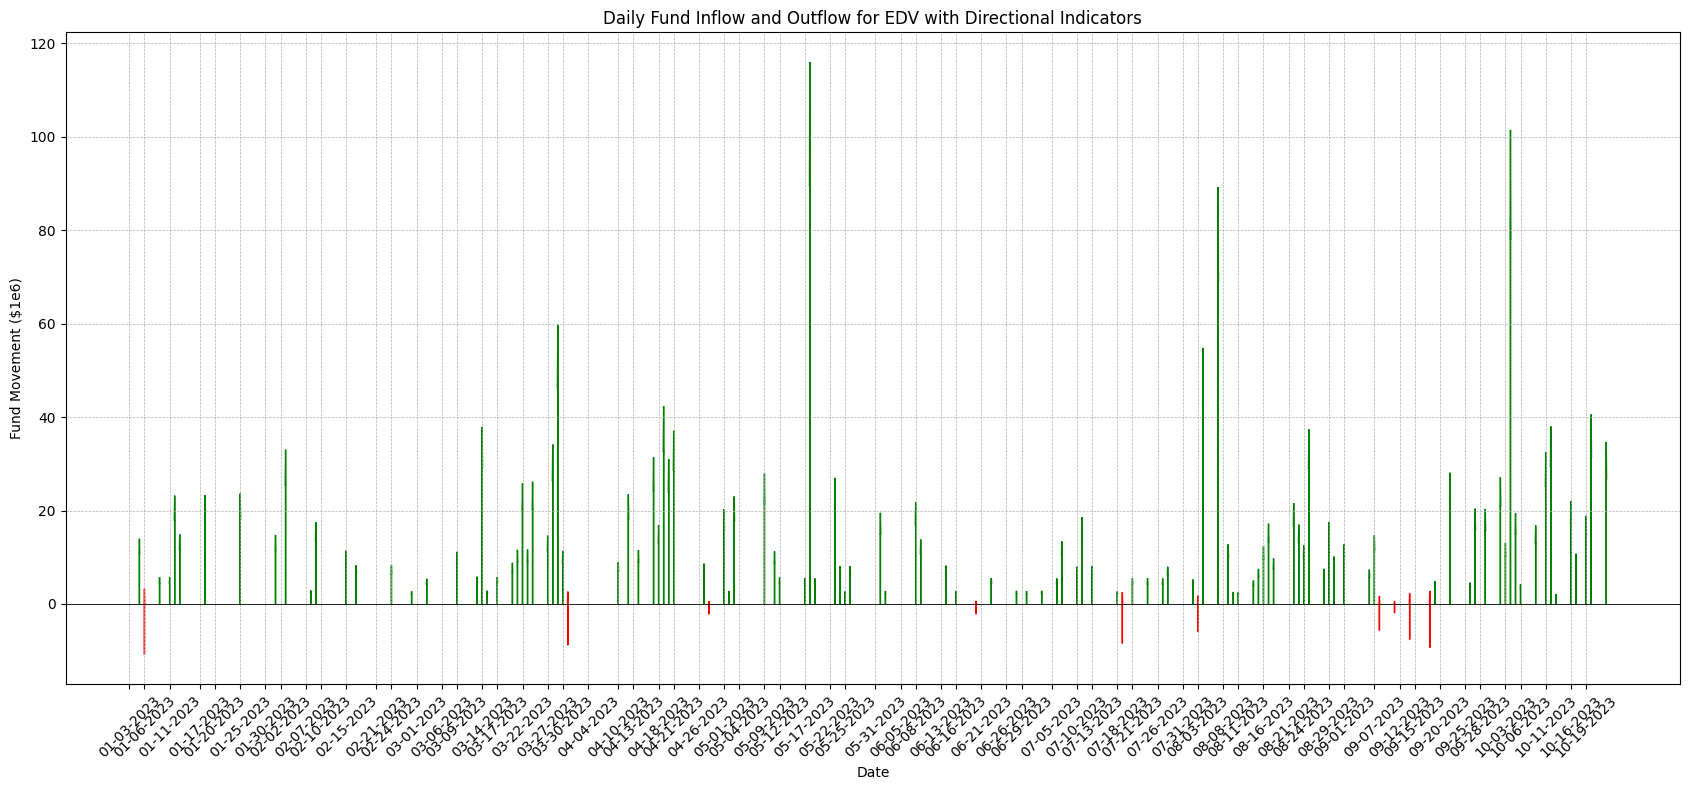

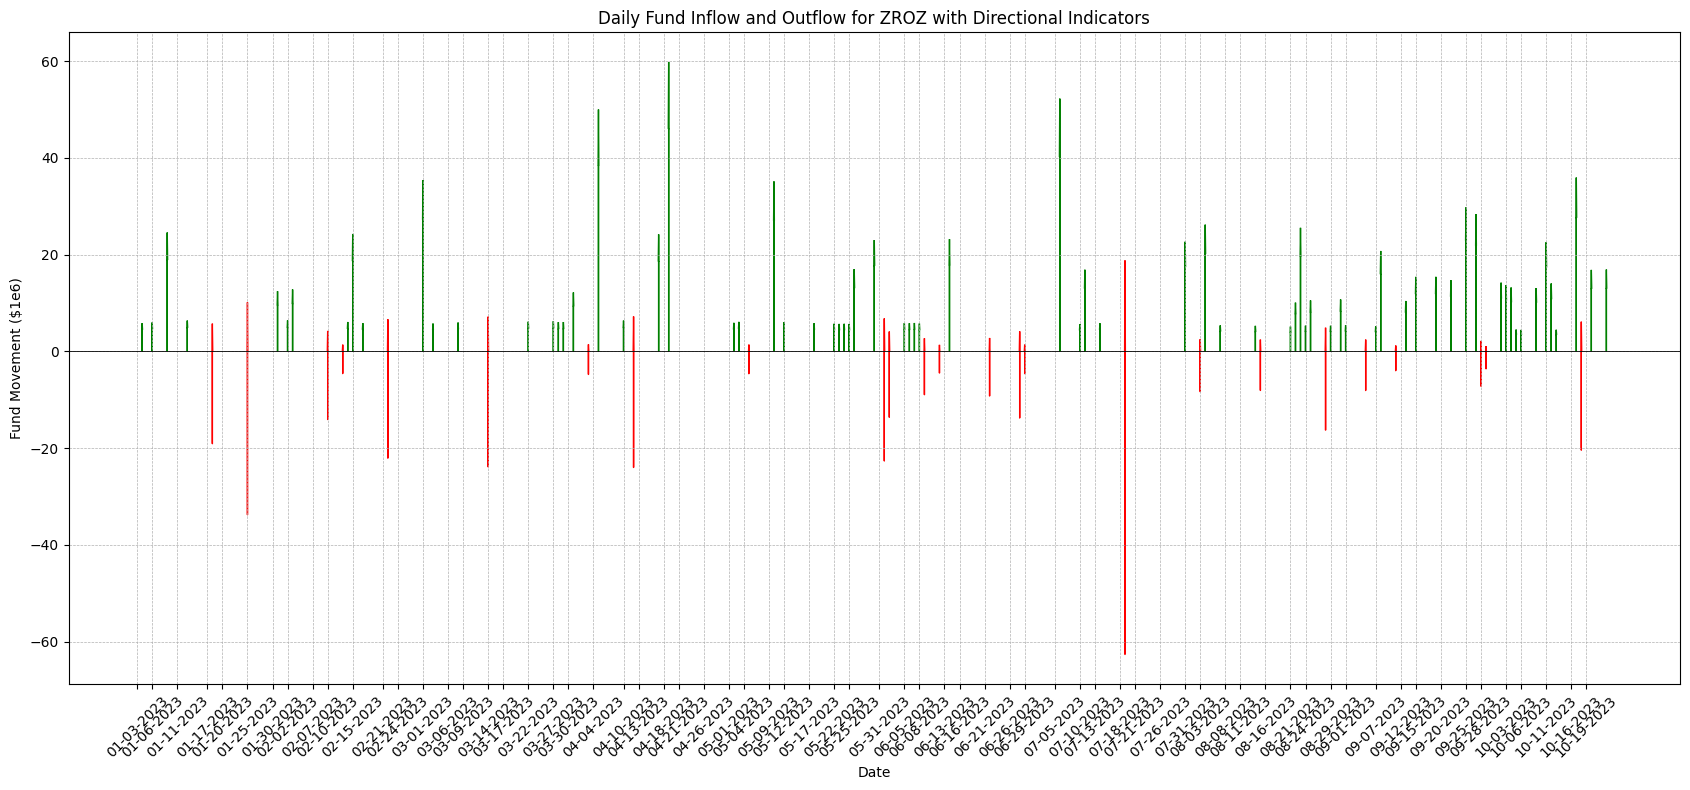

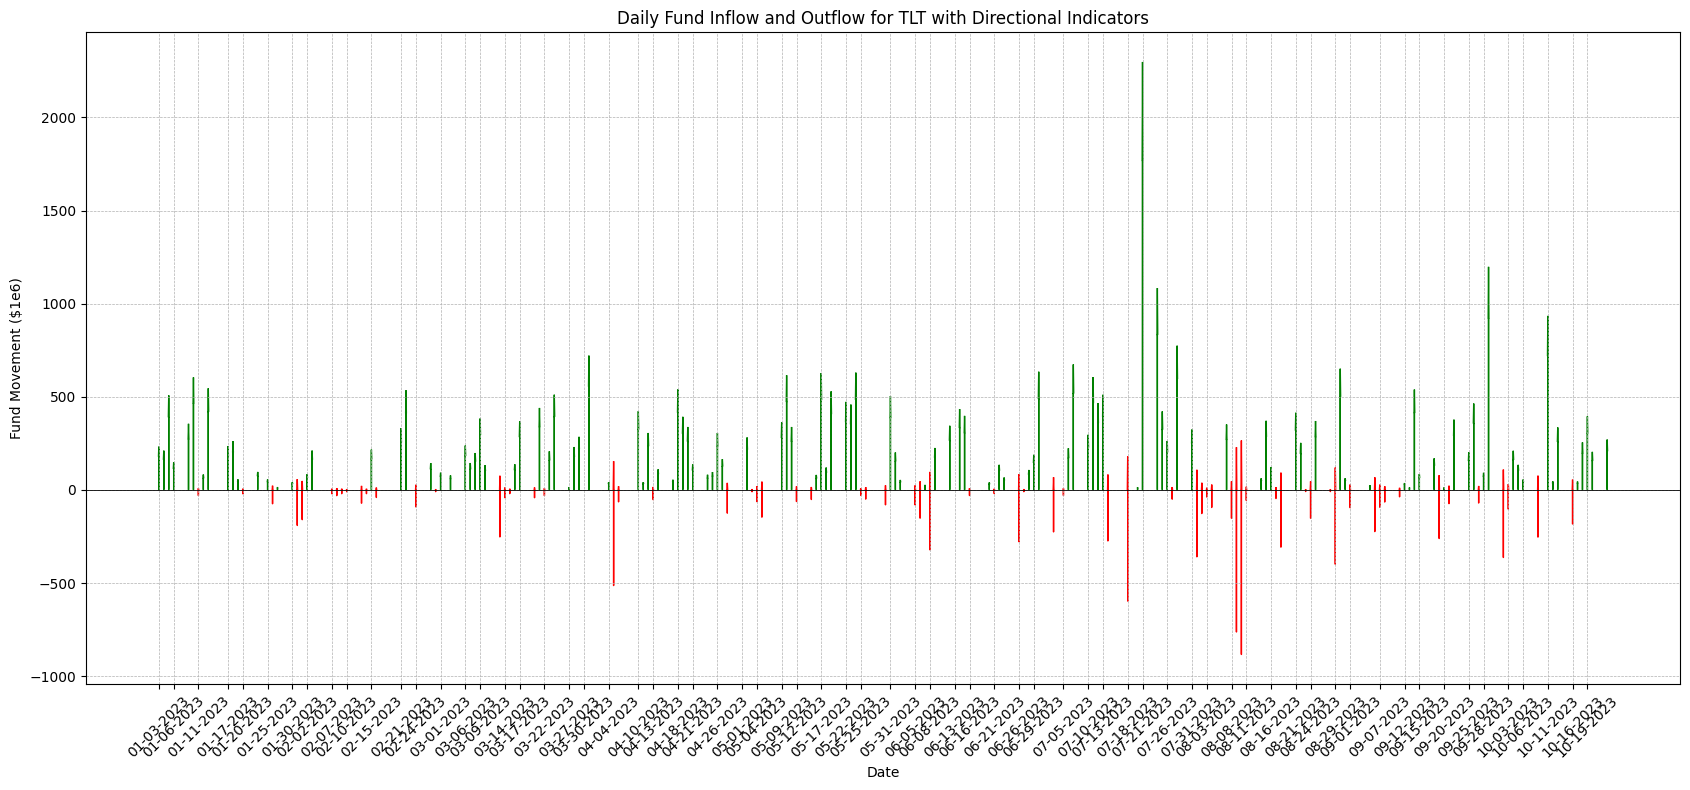

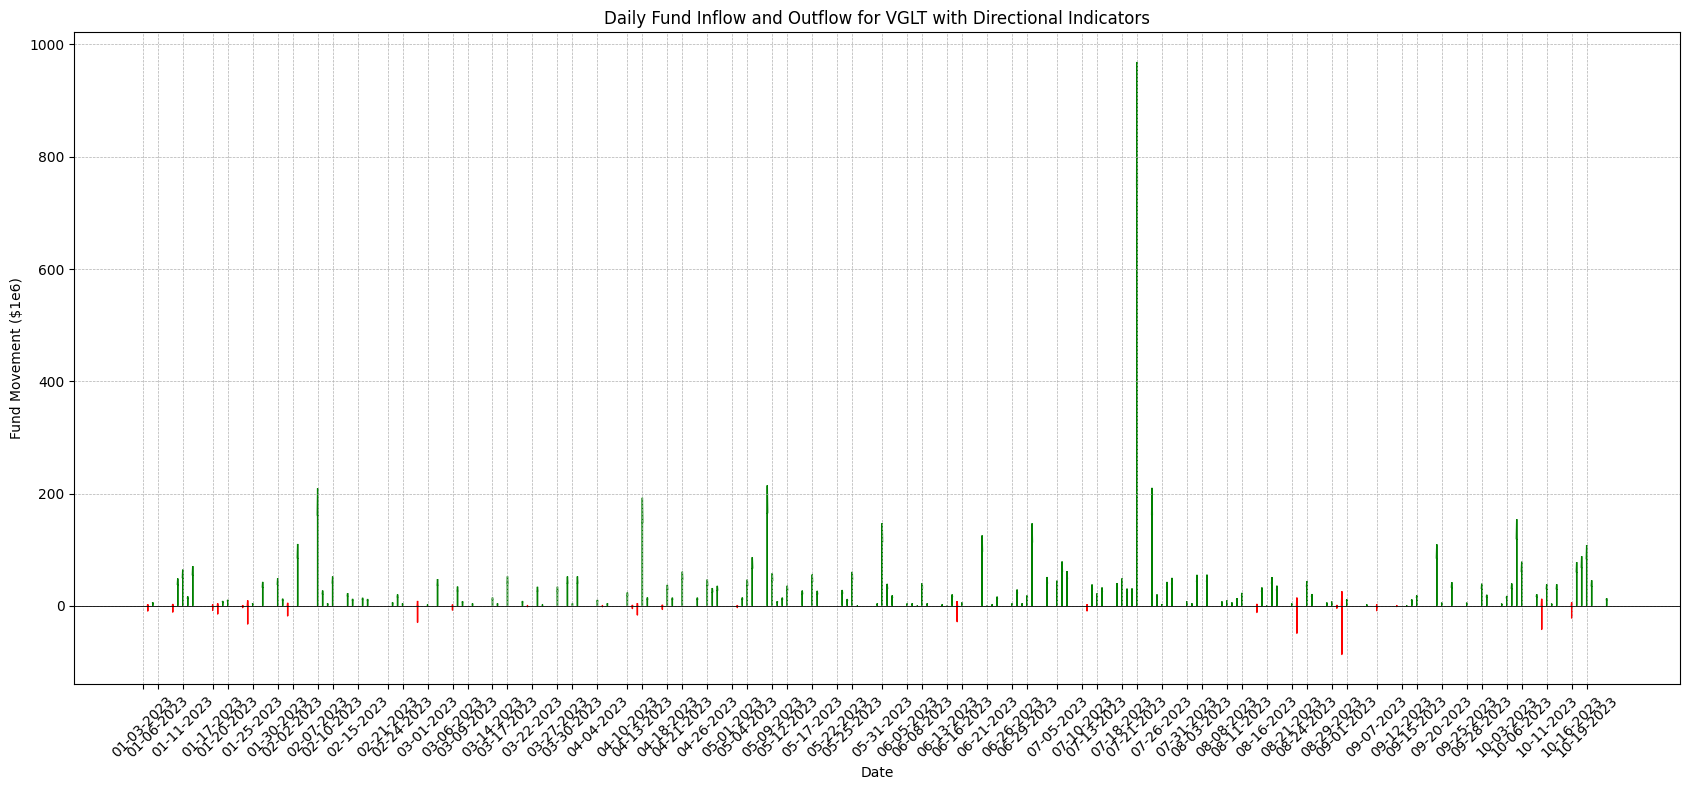

In [97]:
plot_fund_flow_ticks('EDV', 3)
plot_fund_flow_ticks('ZROZ', 3)
plot_fund_flow_ticks('TLT', 3)
plot_fund_flow_ticks('VGLT', 3)

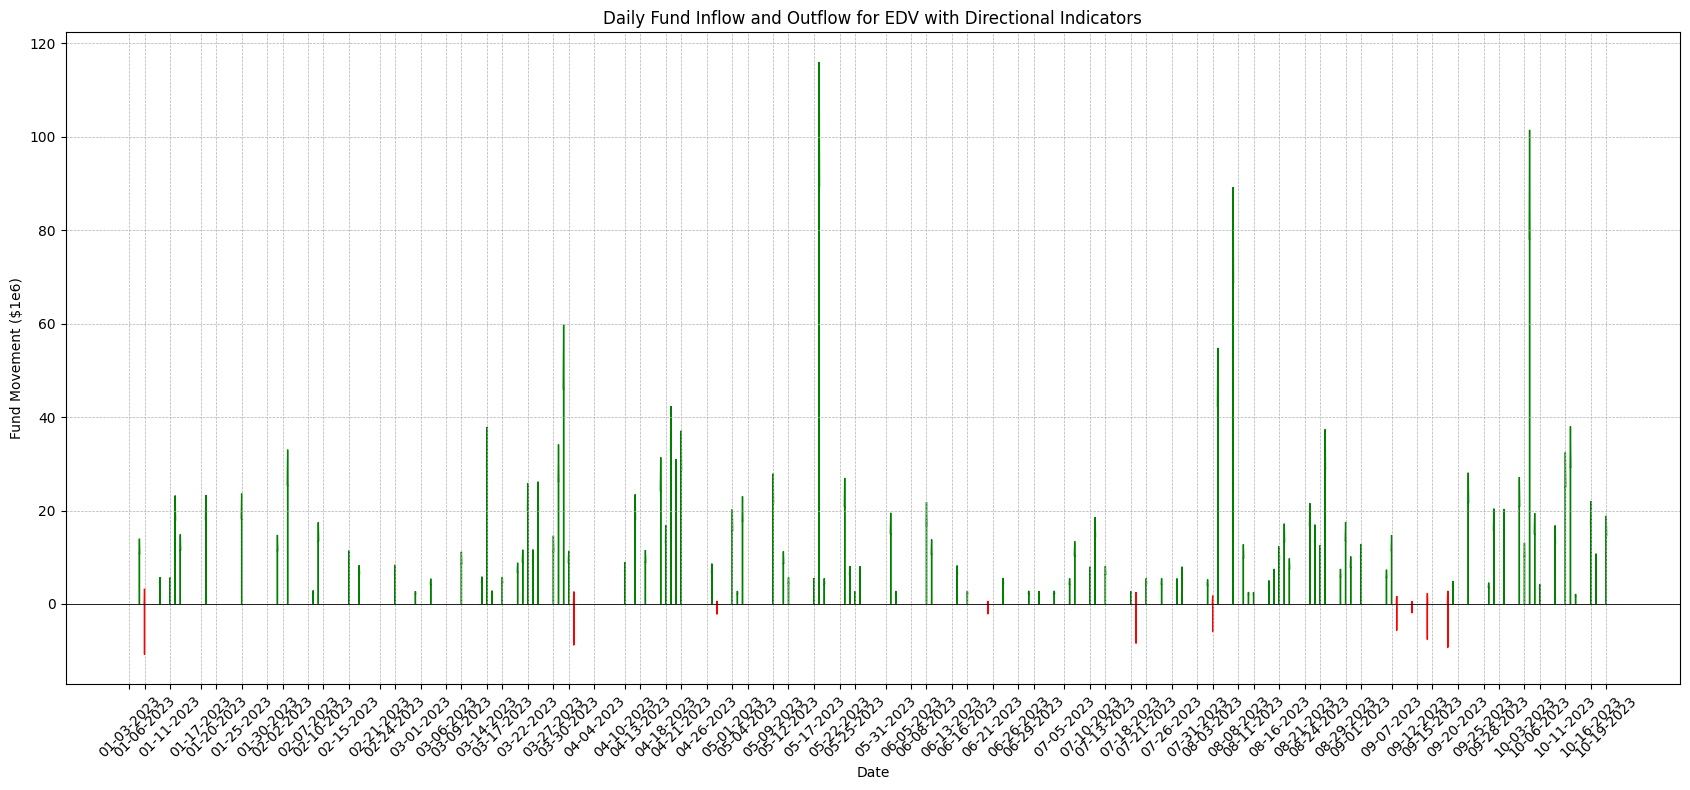

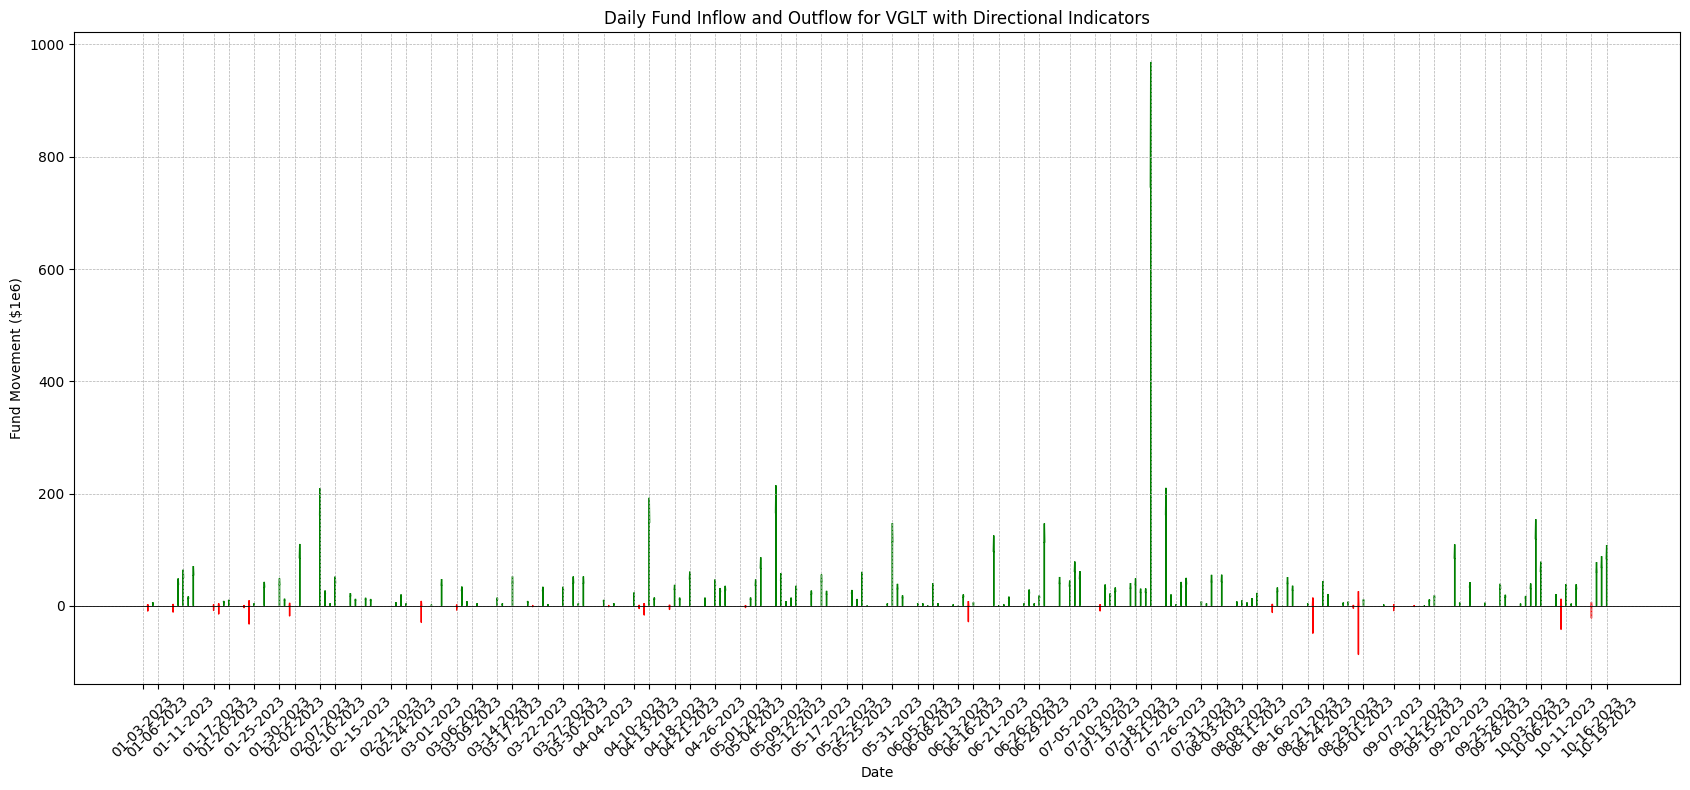

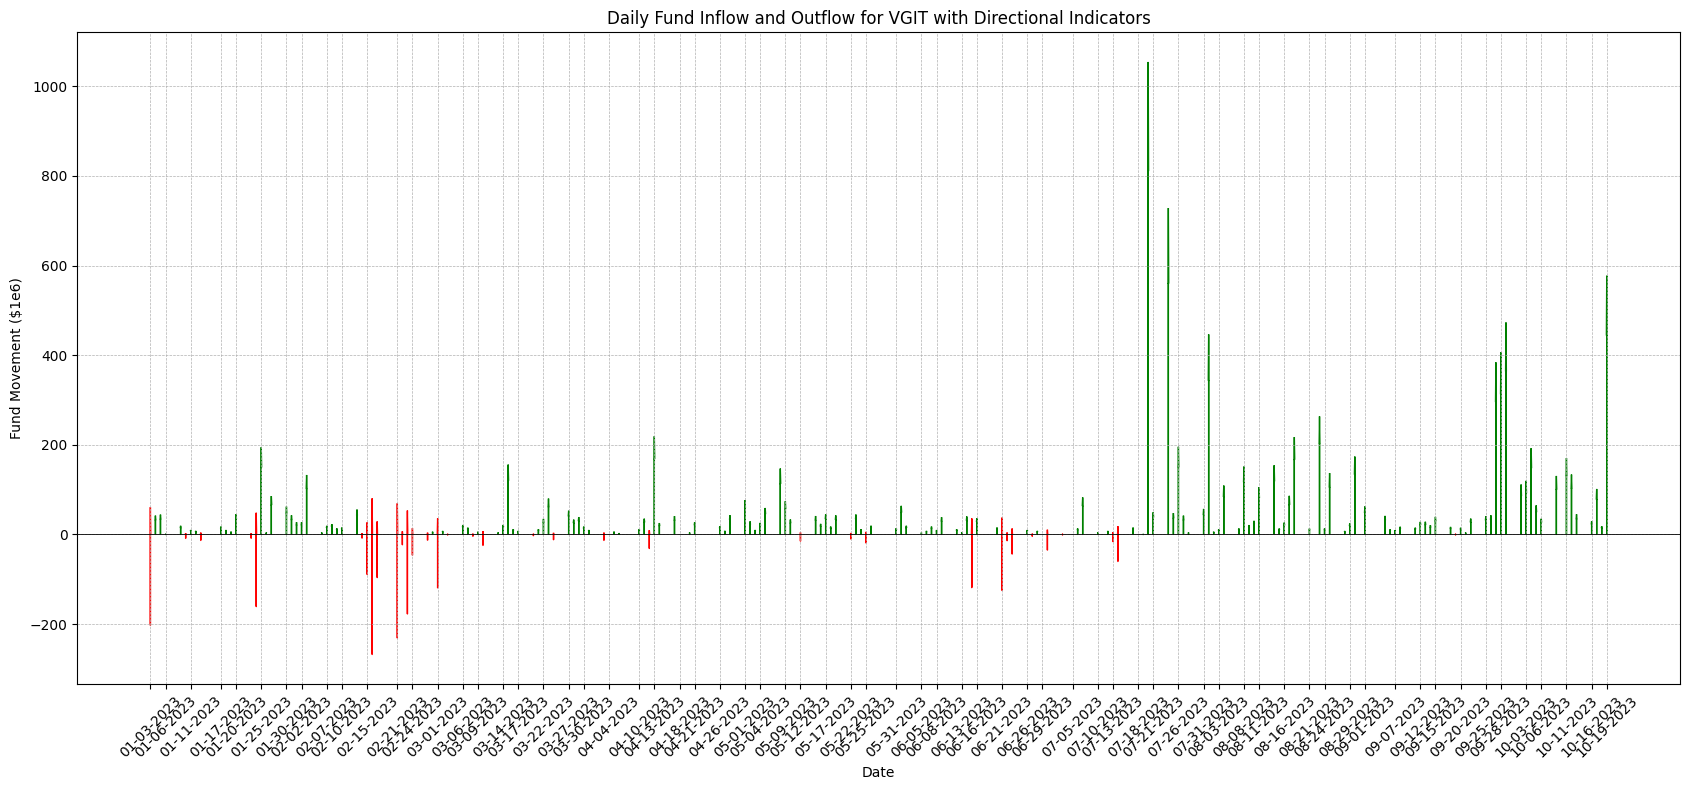

In [9]:
# Vanguard Treasury ETFs Fund Flow (as of 10/23/2023)

plot_fund_flow_ticks('EDV', 3)
plot_fund_flow_ticks('VGLT', 3)
plot_fund_flow_ticks('VGIT', 3)

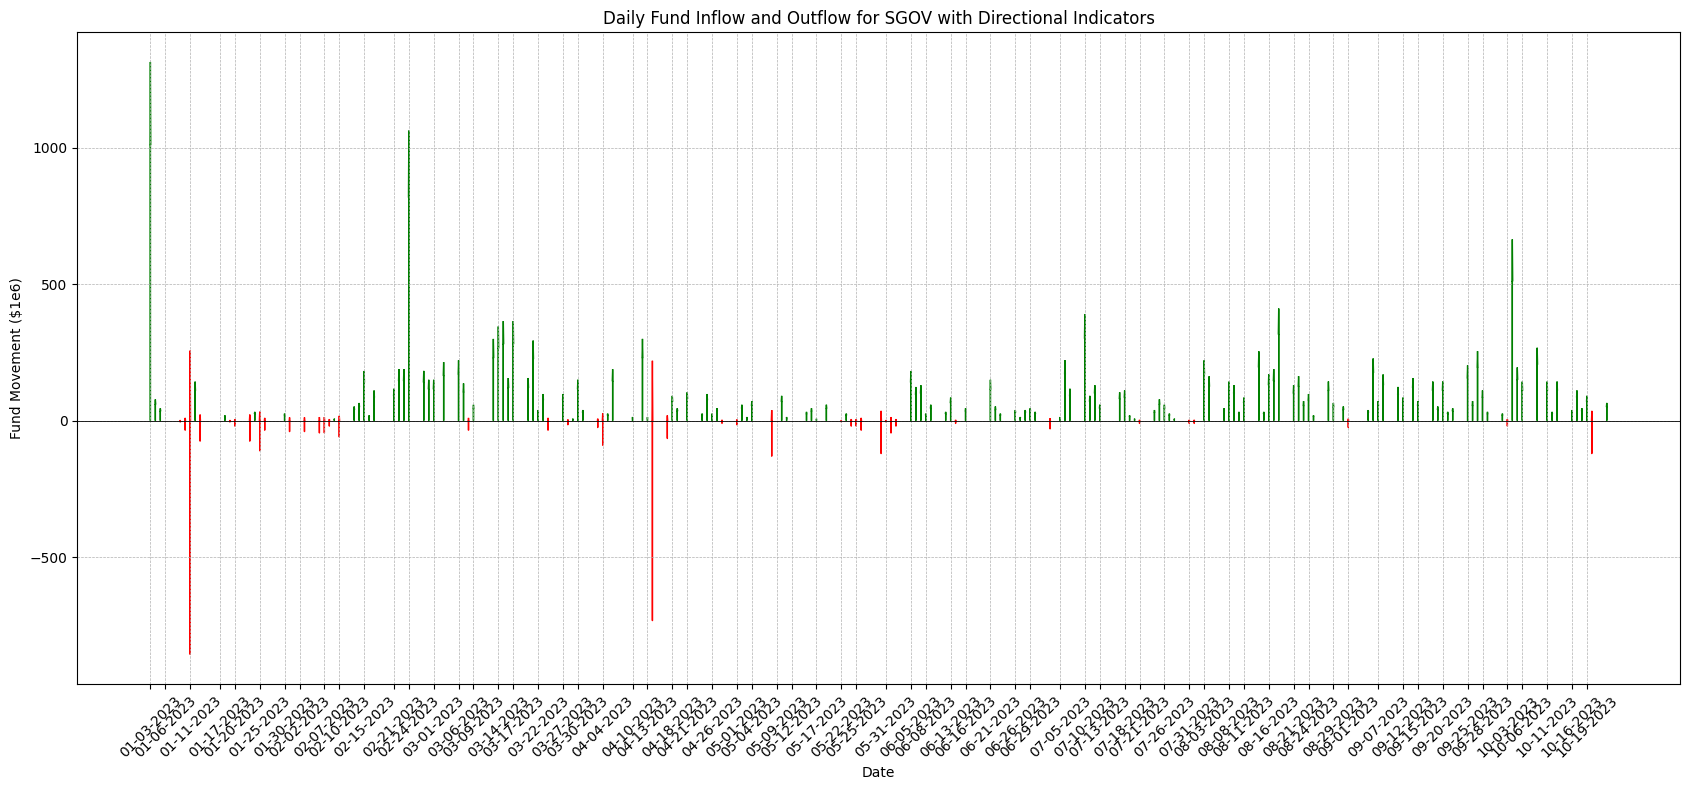

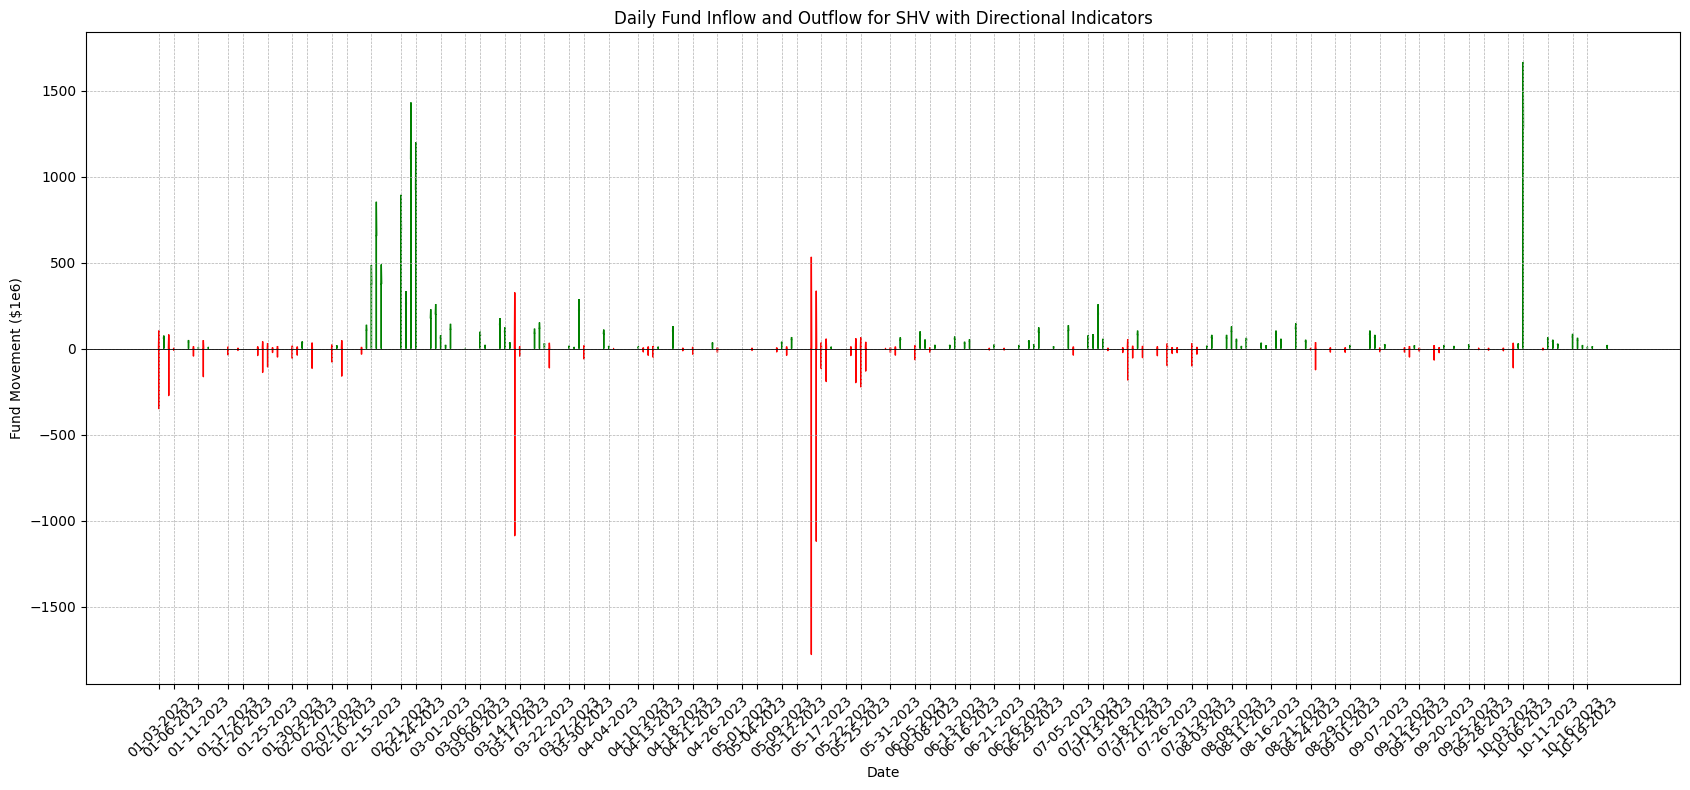

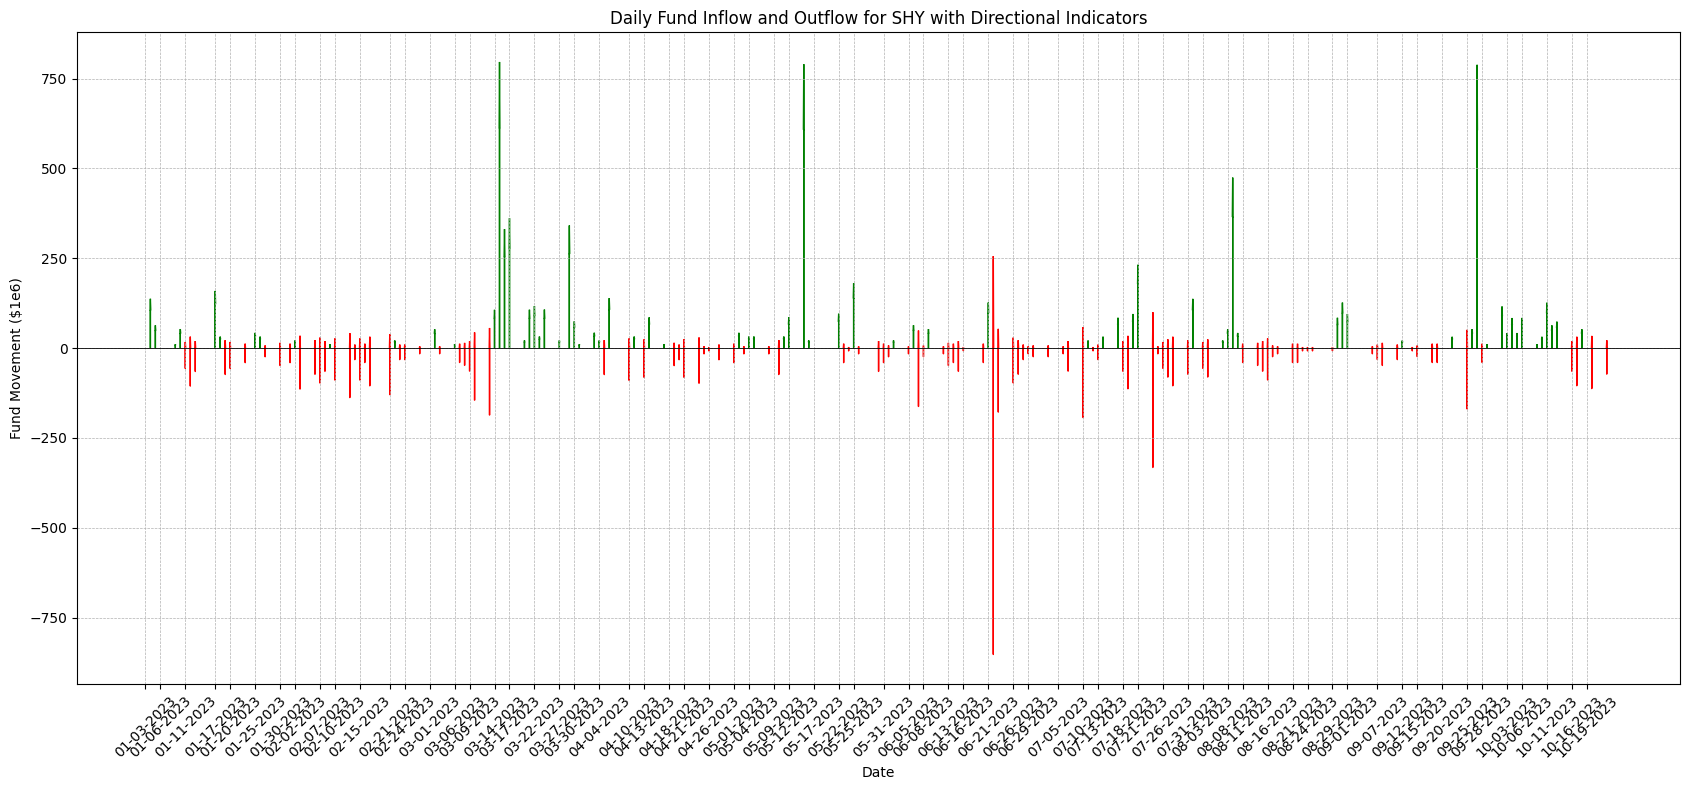

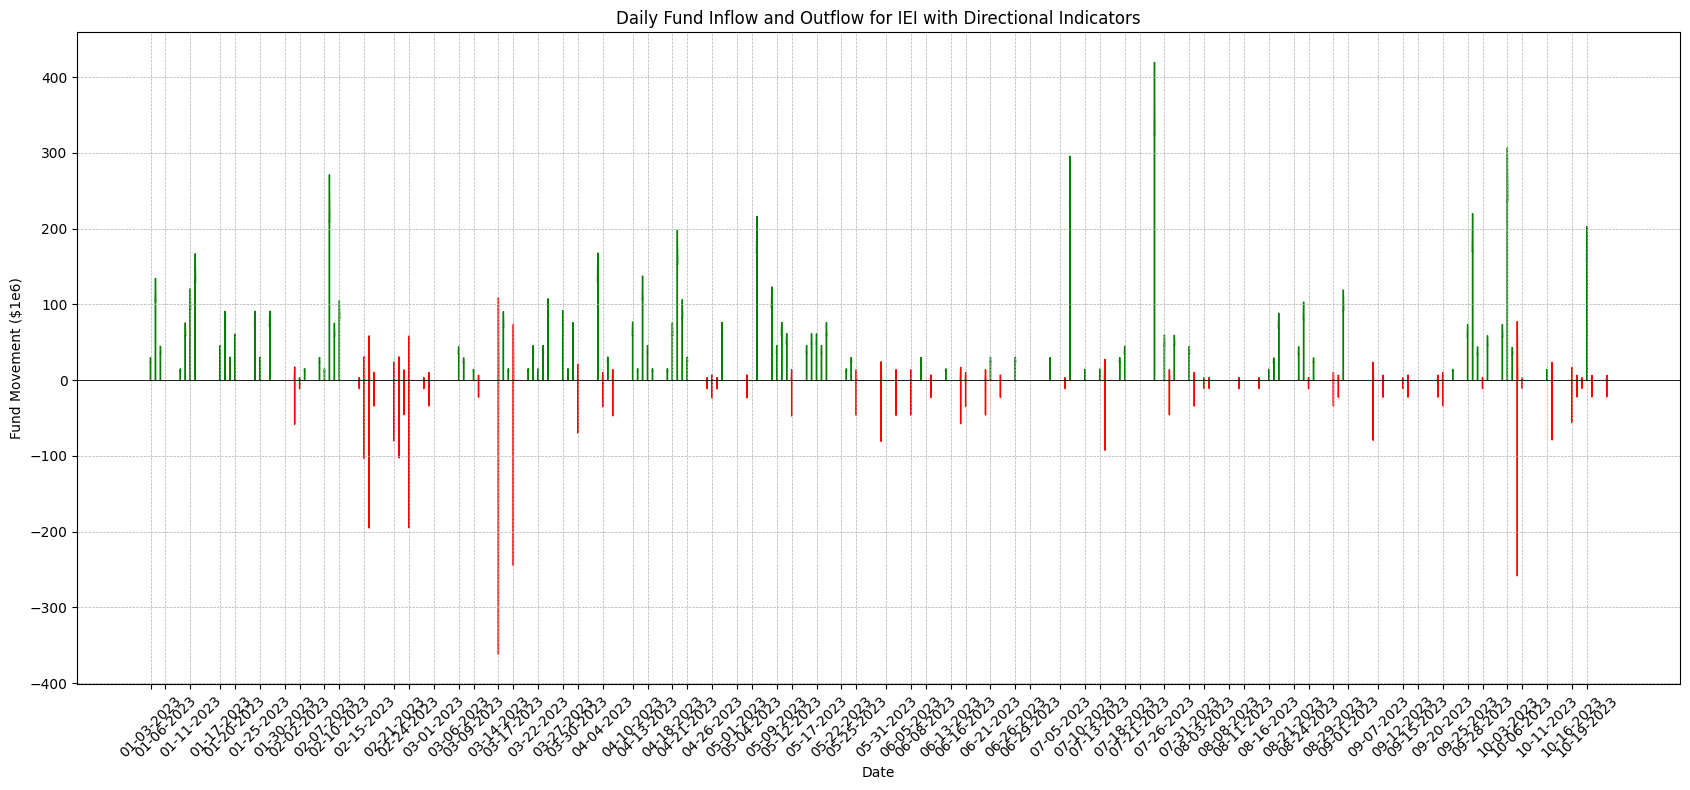

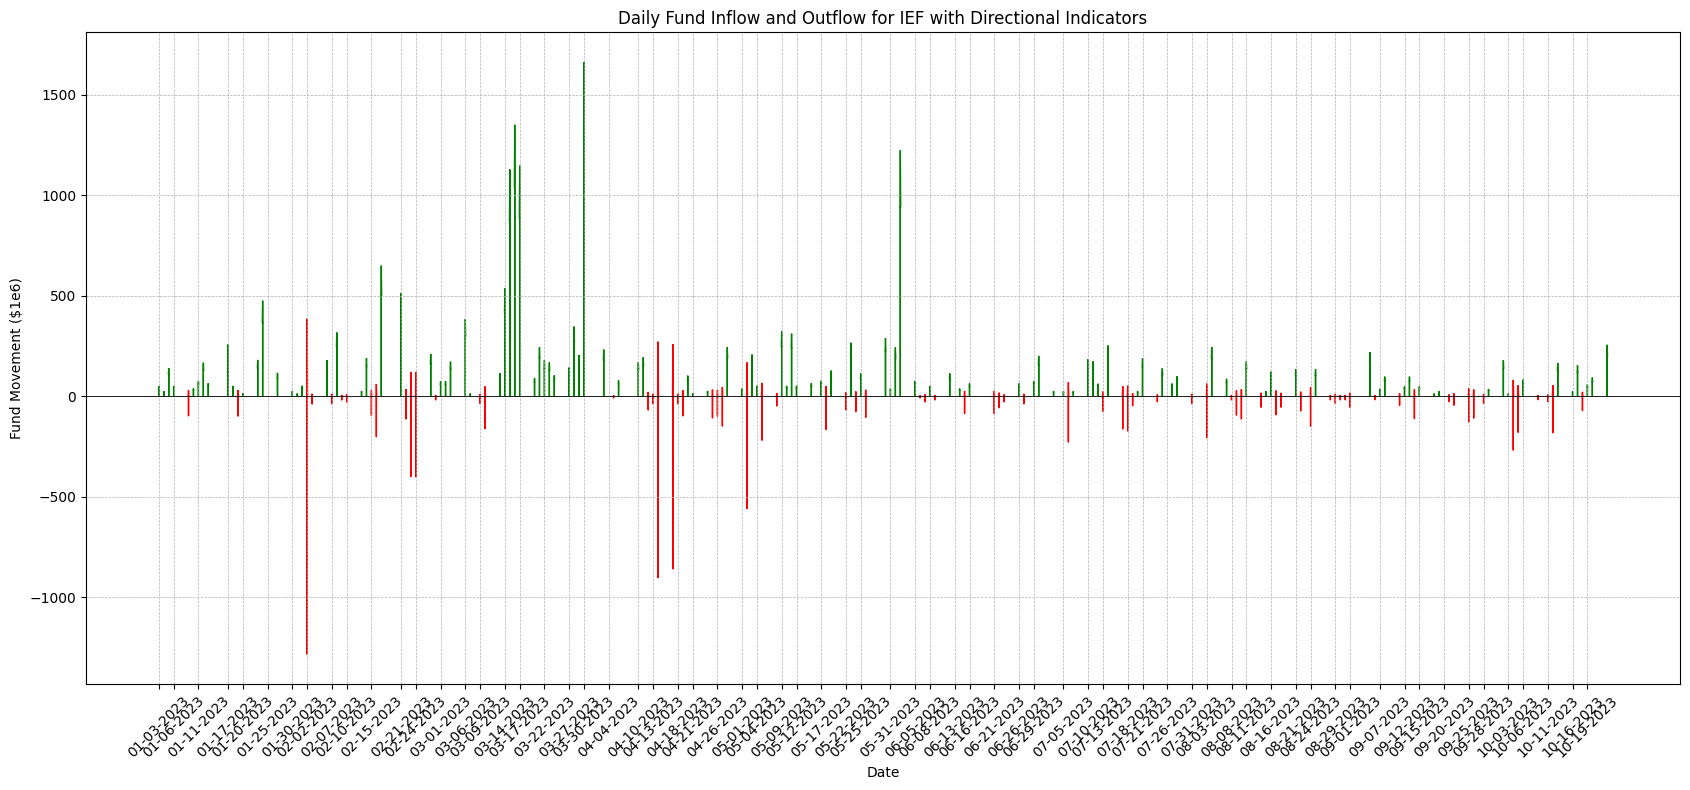

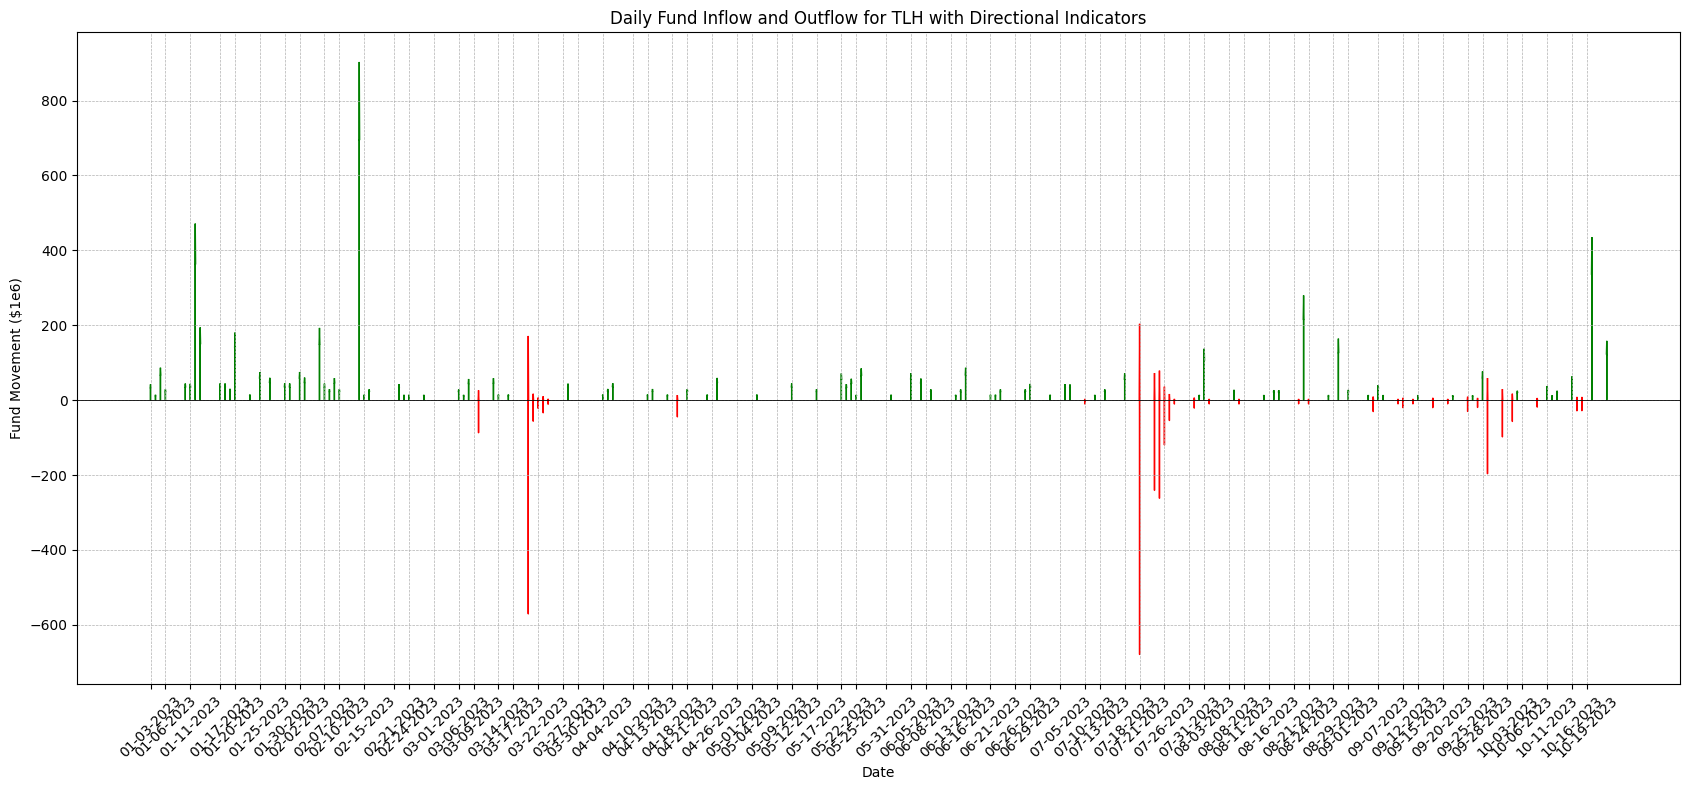

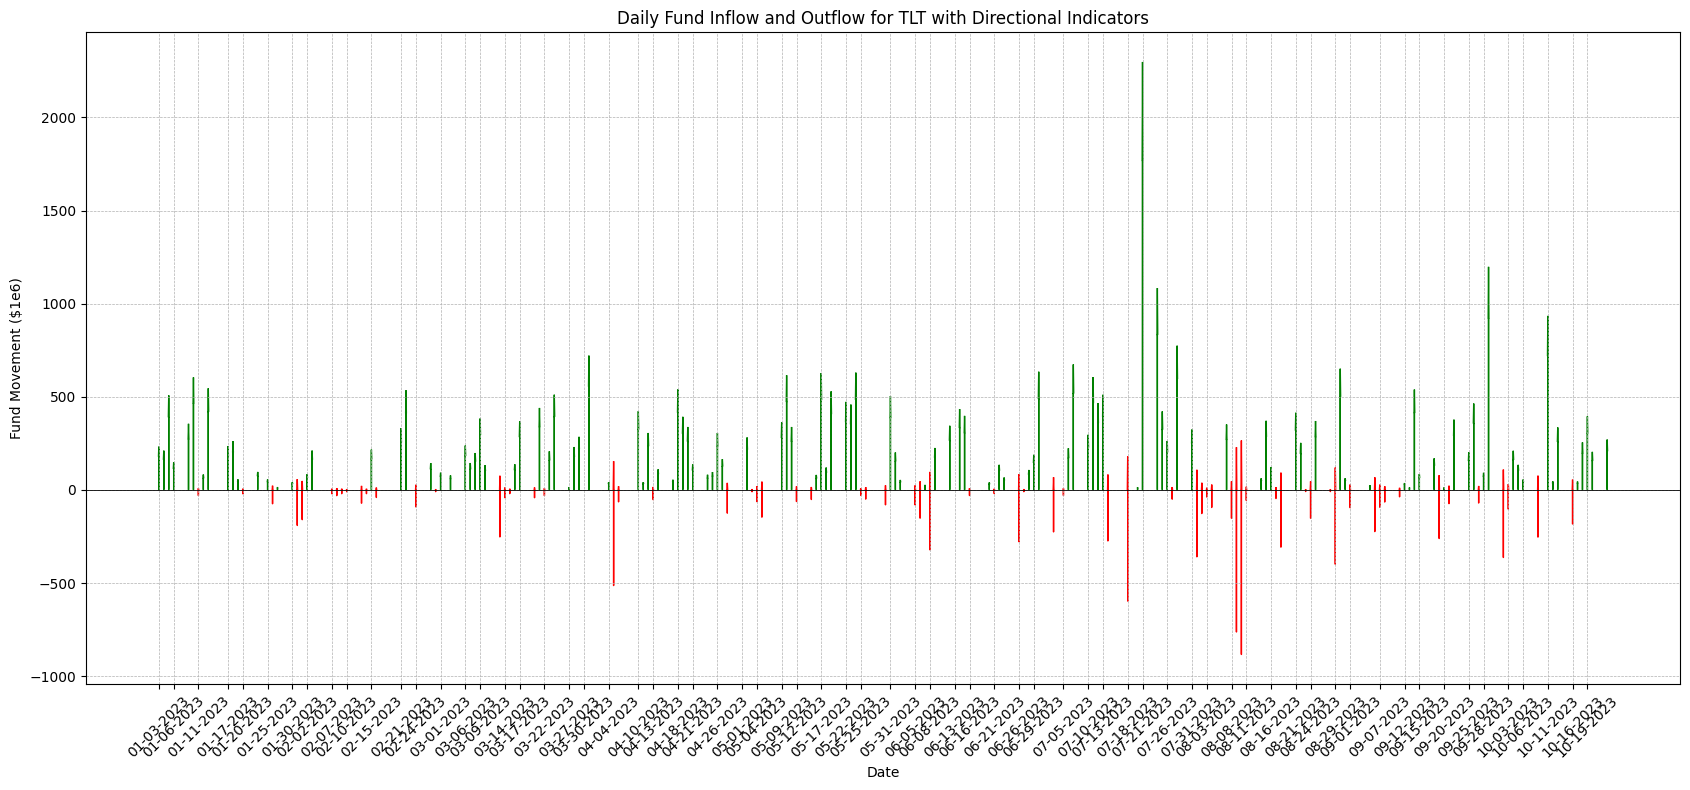

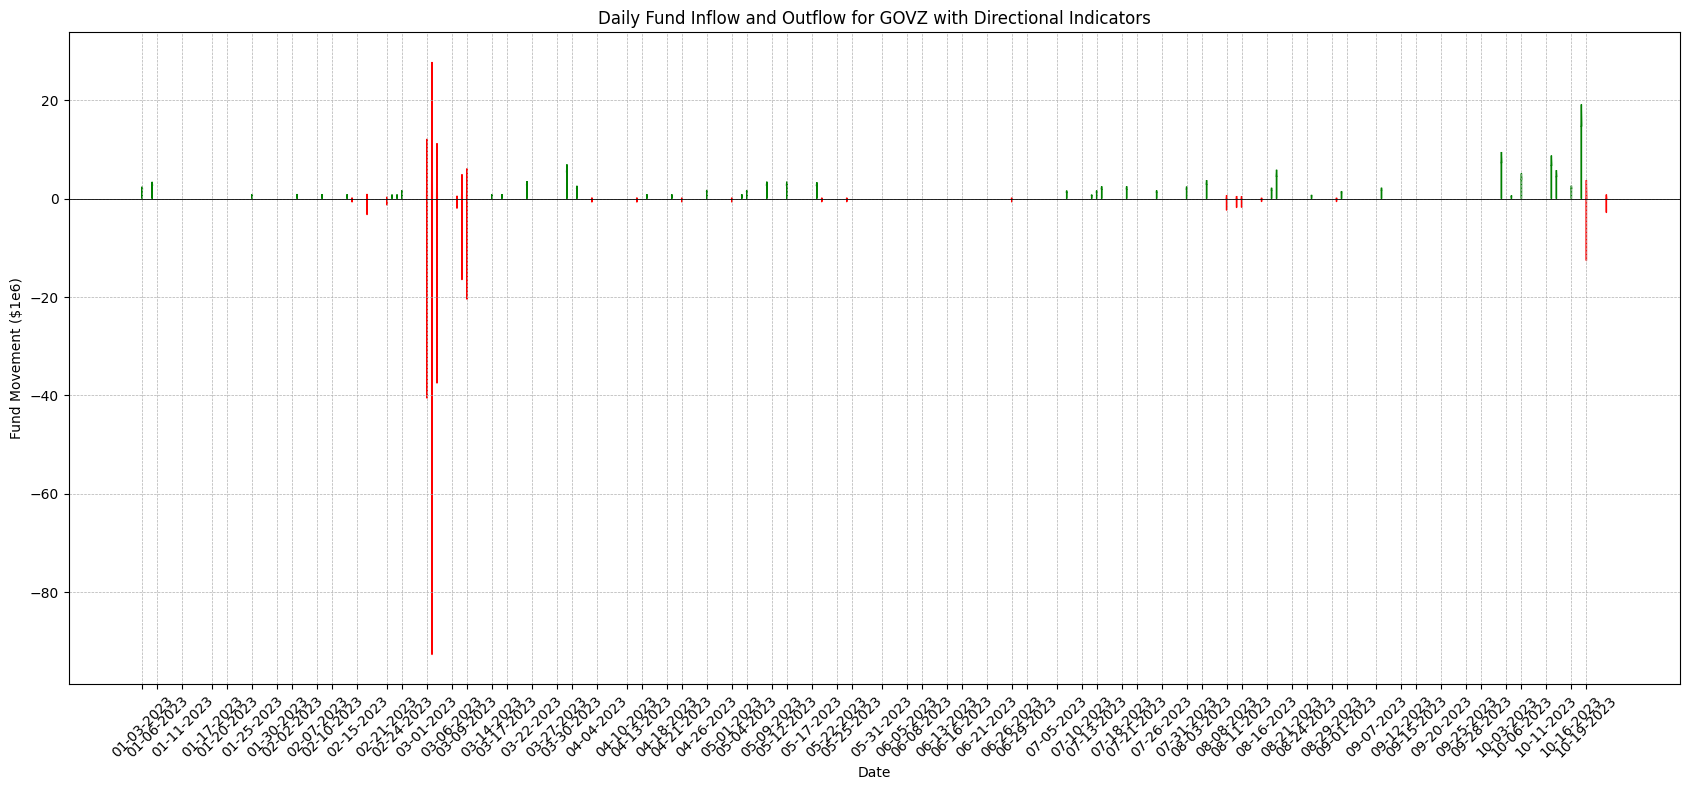

In [8]:
# Blackrock Yield curve maturity segments

# 0-3m
plot_fund_flow_ticks('SGOV', 3)

# 0-1 yr
plot_fund_flow_ticks('SHV', 3)

# 1-3 yr
plot_fund_flow_ticks('SHY', 3)

# 3-7 yr
plot_fund_flow_ticks('IEI', 3)

# 7-10 yr
plot_fund_flow_ticks('IEF', 3)

# 10-20 yr
plot_fund_flow_ticks('TLH', 3)

# 20+ yr
plot_fund_flow_ticks('TLT', 3)

# 25+ yr
plot_fund_flow_ticks('GOVZ', 3)

In [93]:
def get_next_idx(df, current_idx):
    after = df.truncate(before=current_idx).iloc[1:]
    return after.index[0] if 0 < len(after) else None


def get_prev_idx(df, current_idx):
    before = df.truncate(after=current_idx).iloc[:-1]
    return before.index[-1] if 0 < len(before) else None


fund_flow_data_path = r"C:\Users\chris\ETF_Fund_Flows\data\flow\EDV_fund_flow_data.xlsx"
fund_data_path = (
    r"C:\Users\chris\ETF_Fund_Flows\data\yahoofin\EDV_yahoofin_historical_data.xlsx"
)
nav_price_path = (
    r"C:\Users\chris\ETF_Fund_Flows\data\other\EDV_10-23-2023_all_nav_prices.xlsx"
)
# treasury_yield_data_path = r'C:\Users\chris\ETF_Fund_Flows\data\treasury\2023_daily_treasury_rates.xlsx'

fund_flow_df = pd.read_excel(fund_flow_data_path, parse_dates=["asOf"], index_col=0)
fund_flow_df.index.names = ["Date"]
fund_flow_df.rename(columns={"value": "flow"}, inplace=True)
fund_flow_df["flow"] = fund_flow_df["flow"].apply(lambda x: x * 1e6)
fund_flow_df.replace(np.nan, 0, inplace=True)

nav_df = pd.read_excel(nav_price_path, parse_dates=["date"]).sort_values("date")
nav_df["date"] = pd.to_datetime(nav_df["date"], format="%m/%d/%Y")
nav_df = nav_df[nav_df["date"].dt.year == 2023]
nav_df.set_index("date", inplace=True)

fund_data_df = pd.read_excel(fund_data_path, parse_dates=["Date"], index_col=0)
# yields_df = pd.read_excel(treasury_yield_data_path, index_col=0).sort_values('Date')

# df = pd.concat([fund_data_df, nav_df, fund_flow_df, yields_df], axis=1)
df = pd.concat([fund_data_df, nav_df, fund_flow_df], axis=1)
df = df.dropna(subset=['navPrice', 'flow'])


df["navPrice"] = df["navPrice"].str.replace("$", "")
df["navPrice"] = df["navPrice"].str.replace(",", "")
df["navPrice"] = df["navPrice"].astype("float")

df["Premium/Discount"] = (df["Close"] - df["navPrice"]) / df["navPrice"]
df["Premium/Discount Adjusted"] = (df["Adj Close"] - df["navPrice"]) / df["navPrice"]

df["Estimated Daily Creation Units"] = df["flow"] / df["navPrice"]

shares_outstanding_starting = {"date": "2023-09-29", "shares": 31050000}
df["Estimated Shares Outstanding"] = np.nan
df.at[
    shares_outstanding_starting["date"], "Estimated Shares Outstanding"
] = shares_outstanding_starting["shares"]
for idx in df.index:
    if idx > datetime.strptime(shares_outstanding_starting["date"], "%Y-%m-%d"):
        df.loc[idx, "Estimated Shares Outstanding"] = (
            df.loc[get_prev_idx(df, idx), "Estimated Shares Outstanding"]
            + df.loc[idx, "Estimated Daily Creation Units"]
        )
for idx in reversed(df.index):
    if idx < datetime.strptime(shares_outstanding_starting["date"], "%Y-%m-%d"):
        df.loc[idx, "Estimated Shares Outstanding"] = (
            df.loc[get_next_idx(df, idx), "Estimated Shares Outstanding"]
            - df.loc[idx, "Estimated Daily Creation Units"]
        )


df.head()
df.to_excel(r"C:\Users\chris\ETF_Fund_Flows\data\other\temp.xlsx")

C:\Users\chris\AppData\Local\Temp\ipykernel_24012\4169196215.py:39: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["navPrice"] = df["navPrice"].str.replace("$", "")
